# Markov Decision Processes (MDPs)

## Introduction 

Markov Decision Processes (MDPs) provide a foundational framework for formulating sequential decision-making problems under uncertainty. A key characteristic of MDPs is the **Markov assumption**: the optimal action in a given state depends only on the current state and not on the history of previous states.

Formally, an MDP is defined as a tuple $(S, s_0, A, P, R, \gamma)$ consisting of:

*   $S$: A set of states (the state space).
*   $s_0 \in S$: The initial state.
*   $A(s) \subseteq A$: The set of actions applicable in each state $s \in S$.
*   **Transition Model (T):** $P_a(s' \mid s)$ or $T(s, a, s')$, representing the probability of transitioning to state $s'$ from state $s$ when taking action $a \in A(s)$.
*   **Reward Function (R):** $R(s, a, s')$, representing the reward received for transitioning from state $s$ to state $s'$ after taking action $a$. Depending on the problem, the reward function might be defined as $R(s)$ or $R(s, a)$.
*   $\gamma$: A discount factor, where $0 \leq \gamma < 1$.

In the context of this tutorial on learning world models, it's crucial to understand that formulating an MDP requires a known transition model (T) that accurately describes the environment's state transition probabilities. However, in real-world problems, perfect knowledge of the environment is often unavailable. Consequently, we must address uncertainty and aim to select the most likely optimal action based on available information.

## Notebook Objectives
- Formalize our environment as an MDP.
- Introduce the Bellman equation and explore the transition model and discuss potential issues related to scale.
- Introduce algorithms for solving MDPs:
    - Value Iteration
    - Q-Learning

In [1]:
from confs.instances import mdp_config
from helpers.env_utils import load_env
from helpers.metrics_utils import Metrics, TrainingCallback, MetricTracker
from helpers.visualization_utils import plot_episode_rewards
from models.value_iteration import ValueIteration
from agents.vi_agent import ValueIterationAgent
from models.q_learning import QLearning
from agents.ql_agent import QLearningAgent

from os import path
import tqdm
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video

## Environment Configuration
- Fully observable
- Random initialization for the agent
- with a probabilistic transition model (T) for the environment 
	- Robot may slip when attempting to move
- configuration details in `confs.instances.mdp_config`

Environment Model Summary:
	num_free_cells: 29
	num_orientations: 4
	num_states: 116
	num_entities: 5
Transition Model Summary:
	T(s,a,s'): 116 x 3 x 116
Reward Model Summary:
	number of reward states: 4
Actions: ['left', 'right', 'forward']


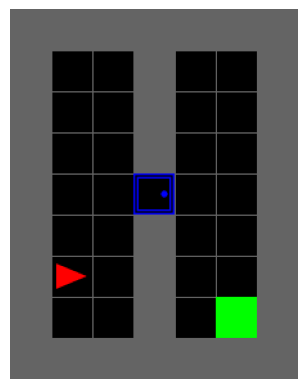

In [2]:
mdp_env = load_env(mdp_config)
observation, info = mdp_env.reset()
env_model = getattr(mdp_env, 'env_model')
env_model.get_summary()
mdp_env.show_render()
valid_actions = getattr(mdp_env, 'valid_actions')
print('Actions: {}'.format([a.name for a in valid_actions]))

## Value Iteration

Value Iteration is a classic algorithm for solving MDPs when we know the transition model. The basic idea is to iteratively improve our estimate of the optimal value function, which tells us how good it is to be in each state. We start with some initial guess for the values and then repeatedly update them based on the Bellman equation. 

$$
V_{k+1}(s) = \max_{a \in A(s)} \left\{ \sum_{s' \in S} T(s, a, s') \left[ R(s, a, s') + \gamma V_k(s') \right] \right\}
$$

This equation considers all possible actions and their resulting states and rewards to find the best action for each state. We keep doing this until the values converge, meaning they don't change much between iterations. This gives us the optimal value function, which we can then use to choose the best actions.

In [3]:
# initialize metrics
metrics = Metrics()
vi_metric_callback = TrainingCallback(metrics, 'value_iteration')
run_metrics_tracker = MetricTracker()

video_path = 'videos/01-mdp/value_iteration/'
video_name_prefix = 'eval'
save_video_freq = 1
num_episodes = 100

run_env = RecordVideo(mdp_env, 
					 video_folder=video_path, 
					 name_prefix=video_name_prefix, disable_logger=True,
                  episode_trigger=lambda x: (x % save_video_freq == 0) or (x == num_episodes-1))

# instantiate VI model
vi_V, policy = ValueIteration(env_model).run()

# initialize agent 
agent = ValueIterationAgent(env_model, policy, vi_metric_callback)
rewards = []

# environment loop
pbar = tqdm.tqdm(range(num_episodes), desc='Running episode')
for episode in pbar:

	obs, info = run_env.reset()
	done = False
	total_reward = 0
	step = 0

	while not done:
		
		action = agent.act(obs)
		next_obs, reward, terminated, truncated, info = run_env.step(action=action)
		step += 1
		obs = next_obs
		total_reward += reward
		done = terminated or truncated
		run_metrics_tracker.track('reward', reward, episode, step)		
		
		if done:
			break

	rewards.append(reward)
	pbar.set_description('Episode [{}/{}] , Total Reward: {:.5f}'.format(episode + 1, num_episodes, total_reward))

vi_metric_callback('episode_reward', run_metrics_tracker.get_episode_total_reward('reward'))

episode_rewards = metrics['value_iteration']['episode_reward']

Value Iteration converged at iters: 108,576


Episode [100/100] , Total Reward: 0.90100: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


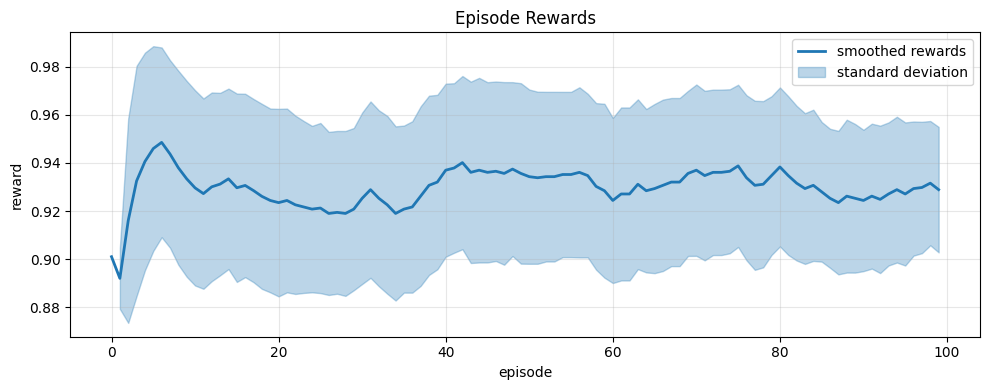

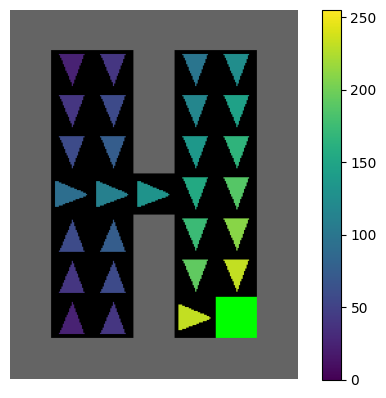

In [4]:
plot_episode_rewards(episode_rewards)
run_env.unwrapped.plot_state_values(vi_V)

video_full_path = path.join(video_path,'{}-episode-{}.mp4'.format(video_name_prefix, 0))
Video(video_full_path)

# Q Learning

We can solve MDPs by learning directly from experience, without knowing the transition model. This involves updating a value function based on a table of (state, action) pairs, which can become computationally expensive for large state and action spaces. Q-learning is a temporal difference learning method that directly learns the optimal action-value function, $Q(s, a)$, which represents the expected cumulative reward for taking action $a$ in state $s$ and following the optimal policy thereafter. The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ R_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right]
$$

Although deep learning-based model-free methods have shown impressive performance, their lack of interpretability poses challenges for real-world deployment. World models offer a potential solution by providing more interpretable representations as a middle-layer before decision-making is done. Furthermore, model-free methods are generally less data-efficient than model-based approaches, which, while requiring data to learn world dynamics, make more assumptions about the environment.

In [5]:
# initialize metrics
metrics = Metrics()
q_metric_callback = TrainingCallback(metrics, 'q_learning')
run_metrics_tracker = MetricTracker()

video_path = 'videos/01-mdp/q_learning/'
video_name_prefix = 'training'
save_video_freq = 200
num_episodes = 600

run_env = RecordVideo(mdp_env, 
					 video_folder=video_path, 
					 name_prefix=video_name_prefix, disable_logger=True,
                  episode_trigger=lambda x: (x % save_video_freq == 0) or (x == num_episodes-1))

# instantiate QLearning model
Q_learning_policy = QLearning(env_model)

# initialize agent 
agent = QLearningAgent(Q_learning_policy, q_metric_callback)

rewards = []

# environment loop
pbar = tqdm.tqdm(range(num_episodes), desc='Running episode')
for episode in pbar:

	obs, info = run_env.reset()
	done = False
	total_reward = 0
	step = 0

	while not done:
		
		action = agent.act(obs)
		next_obs, reward, terminated, truncated, info = run_env.step(action=action)
		# update the Q-table
		agent.update(obs, action, reward, next_obs, terminated)
		step += 1
		obs = next_obs
		total_reward += reward
		done = terminated or truncated
		run_metrics_tracker.track('reward', reward, episode, step)		
		
		if done:
			break

	rewards.append(reward)
	pbar.set_description('Episode [{}/{}] , Total Reward: {:.5f}'.format(episode + 1, num_episodes, total_reward))

q_metric_callback('episode_reward', run_metrics_tracker.get_episode_total_reward('reward'))

episode_rewards = metrics['q_learning']['episode_reward']

Episode [600/600] , Total Reward: 0.00000: 100%|██████████| 600/600 [00:20<00:00, 29.58it/s]


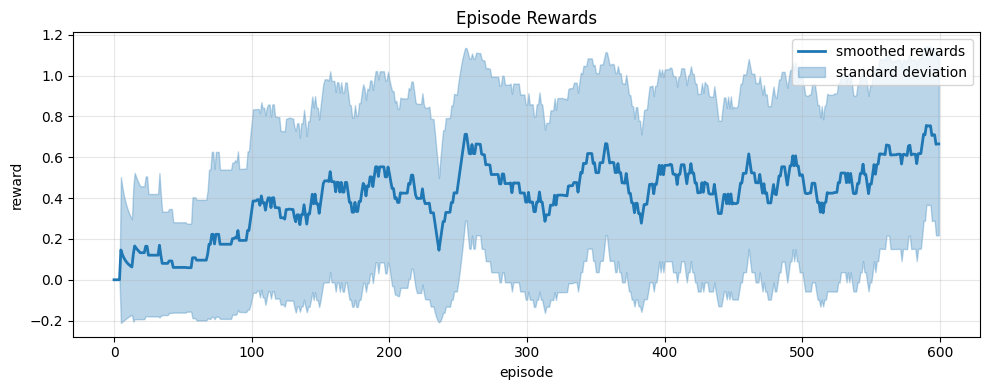

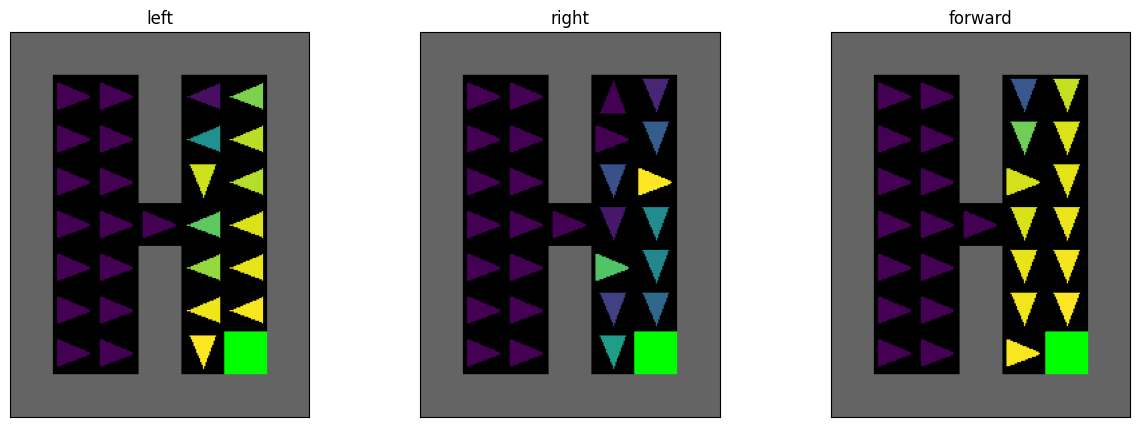

In [6]:
plot_episode_rewards(episode_rewards)
run_env.unwrapped.plot_state_values(Q_learning_policy.Q_lookup)

video_full_path = path.join(video_path,'{}-episode-{}.mp4'.format(video_name_prefix, num_episodes-1))
Video(video_full_path)